In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from PIL import Image
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
from random import shuffle, seed
from glob import glob
import os

# Global variables

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Reading dataset

In [3]:
!pip install -q kaggle

In [4]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"soroushmehraban","key":"ead0a55ee025b71704cd8ce9a236c86a"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [6]:
!kaggle datasets download -d tongpython/cat-and-dog

 97% 212M/218M [00:01<00:00, 170MB/s]
100% 218M/218M [00:01<00:00, 163MB/s]


In [ ]:
!unzip cat-and-dog.zip

In [8]:
train_data_dir = 'training_set/training_set/'
test_data_dir = 'test_set/test_set/'

In [9]:
class CatsDogs(Dataset):
    def __init__(self, folder):
        cats = glob(f"{folder}/cats/*.jpg")
        dogs = glob(f"{folder}/dogs/*.jpg")
        self.fpaths = cats[:500] + dogs[:500]
        
        self.normalize = transforms.Normalize(mean=[0.485, 0.465, 0.406],
                                              std=[0.229, 0.224, 0.225]) # MANDATORY FOR TRANSFER LEARNING
        
        # Randomize
        shuffle(self.fpaths)
        self.targets = [fpath.split(os.sep)[-1].startswith('dog') for fpath in self.fpaths] # dog = 1, cat = 0
    
    def __len__(self):
        return len(self.fpaths)
    
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:, :, ::-1])
        im = cv2.resize(im, (224, 224)) # MANDATORY FOR TRANSFER LEARNING
        im = torch.tensor(im / 255)
        im = im.permute(2, 0, 1) # MANDATORY FOR TRANSFER LEARNING
        im = self.normalize(im) # MANDATORY FOR TRANSFER LEARNING
        return im.float().to(device),  torch.tensor([target]).float().to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.], device='cuda:0')


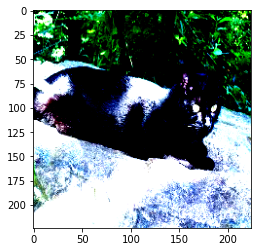

In [10]:
data = CatsDogs(train_data_dir)
im, label = data[200]
plt.imshow(im.permute(1, 2, 0).cpu())
print(label)

# Define the model

In [11]:
def get_model():
    model = models.vgg16(pretrained=True)
    
    # Freeze all the parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Change avgpool to return feature map of 1x1
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    
    # Define the classifier
    model.classifier = nn.Sequential(
                            nn.Flatten(),
                            nn.Linear(512, 128),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(128, 1),
                            nn.Sigmoid()
                        )
    
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model.to(device), loss_fn, optimizer

In [12]:
model, criterion, optimizer = get_model()
summary(model, input_size=(3, 224, 224))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

**Only 65,793 (65,664 + 129) parameters are trainable**.

# Functions

In [13]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

In [14]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [15]:
def get_data():
    train = CatsDogs(train_data_dir)
    train_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
    
    val = CatsDogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last=True)
    
    return train_dl, val_dl

# Train the model

In [16]:
train_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [17]:
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(5):
    print(f"epoch {epoch + 1} of 5")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    
    for batch in train_dl:
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
        
    for batch in train_dl:
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    
    for batch in val_dl:
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

epoch 1 of 5
epoch 2 of 5
epoch 3 of 5
epoch 4 of 5
epoch 5 of 5


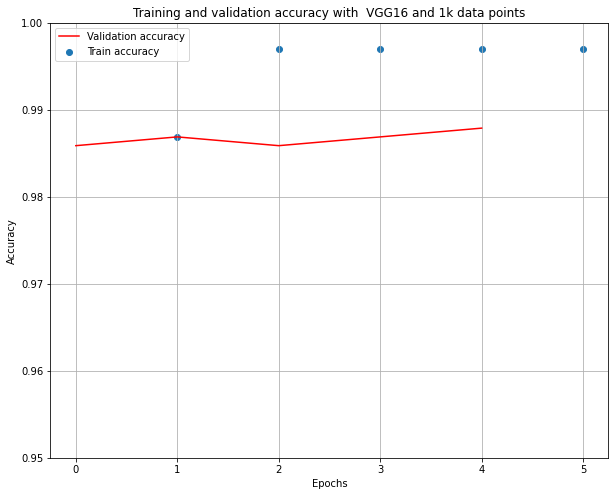

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))

epochs = [i for i in range(1, 6)]

# Add data to ax
ax.scatter(x=epochs,
            y=train_accuracies)
ax.plot(val_accuracies, color='red')
ax.set_ylim(0.95, 1)

# Customize ax
ax.set(title= "Training and validation accuracy with  VGG16 and 1k data points",
        ylabel= "Accuracy",
        xlabel= "Epochs")

# Add legend to ax
ax.legend(['Validation accuracy', 'Train accuracy'])

# Configure the grid lines
ax.grid('on');